### **Equivariant Diffusion Model**

We also explored the use of E. Hoogeboom's proposed Equivariant Diffusion Model, an extension of the EGNN model. Because the model was built to run on the QM9 and GEOM datasets, we have had to reconfigure the protein dataset (CATH .pdb files) and model components. In particular, we approximated and represented elements along the protein backbone sequence with the C-alpha atom. The atom type is encoded with an integer with each integer representing a side-chain. Categorical variables are the one-hot encoded representation of the amino acid side chain type.

In [ ]:
# Google Colab Setup

# from google.colab import drive
# drive.mount('/content/drive')
# cd /content/drive/MyDrive/CS5284\ Project/protein-coordinates/notebooks
# !pip install pytorch matplotlib pandas seaborn scikit-learn torchvision numpy scipy dgl imageio biopython ipykernel ipywidgets wandb
#pip install biopython

In [1]:
import sys

sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.PDB import PDBList, PDBParser
import os
import torch
import torch.nn as nn
from data_read_edm import *
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

### Data Retrieval

In [ ]:
# Option to pull dataset from biopython's PDBList library

# def download_pdb_files(sample_size=100):
#     """
#     Retrieves all PDB IDs available in the PDB.

#     Returns:
#         list: List of all PDB IDs.
#     """
#     np.random.seed(42)
#     pdbl = PDBList()
#     pdb_ids = pdbl.get_all_entries()
#     sampled_pdb_ids = np.random.choice(pdb_ids, sample_size, replace=False)
#     for pdb_id in sampled_pdb_ids:
#         pdbl.retrieve_pdb_file(pdb_id, pdir='pdb_files', file_format='pdb')
#     print(f"Downloaded {len(sampled_pdb_ids)} PDB files.")
#     return pdb_ids

# download_pdb_files(sample_size=500)

In [ ]:
# Organizing of pdb files into train, test folders

import shutil
from sklearn.model_selection import train_test_split

# Define the paths
data_path = '../data/dompdb/'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

# Create train and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get list of all files in the data_path
all_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

# Split the files into train and test sets
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Move the files to the respective directories
for file in train_files:
    shutil.move(os.path.join(data_path, file), os.path.join(train_path, file))

for file in test_files:
    shutil.move(os.path.join(data_path, file), os.path.join(test_path, file))

print(f"Moved {len(train_files)} files to {train_path}")
print(f"Moved {len(test_files)} files to {test_path}")

Moved 1112 files to ../data/dompdb/train
Moved 279 files to ../data/dompdb/test


### Testing of Datasets and DataLoaders

In [9]:
from src.dataset.datasets import *
from src.dataset.transforms import *
from torchvision import transforms

In [10]:
pdb_transforms = transforms.Compose([NormalizeCoordinates()])

In [12]:
train_data_path = 'data/dompdb/train'
test_data_path = 'data/dompdb/test'
train_dataset = PDBDataset(train_data_path, transforms=pdb_transforms)
if len(train_dataset)%2 != 0:
    train_dataset = train_dataset[:-1]
test_dataset = PDBDataset(test_data_path, transforms=pdb_transforms)

100%|██████████| 6377/6377 [00:57<00:00, 110.33it/s]


### Data Statistics

Generating of variables to help us see the distribution of chain lengths, and amino acid side chain types. Also forms essential components that the model requires.

In [13]:
from collections import defaultdict

# Initialize a dictionary to store the count of samples with each number of nodes
node_count_dict = defaultdict(int)

# Enumerate through the train_dataset and count the number of nodes in each sample
max_nodes = 0
for sample in train_dataset:
    num_nodes = sample['positions'].shape[0]
    node_count_dict[num_nodes] += 1
    if num_nodes > max_nodes:
        max_nodes = num_nodes

for sample in test_dataset:
    num_nodes = sample['positions'].shape[0]
    if num_nodes > max_nodes:
        max_nodes = num_nodes

# Initialize a dictionary to store the count of occurrences for each unique value in ["i_seq"]
i_seq_count_dict = defaultdict(int)

# Enumerate through the train_dataset and count the occurrences of each unique value in ["i_seq"]
for sample in train_dataset:
    for i_seq_value in sample['i_seq']:
        if i_seq_value != 0:
            i_seq_count_dict[i_seq_value.item()] += 1

# Sort the keys of i_seq_count_dict
i_seq_count_dict = dict(sorted(i_seq_count_dict.items()))

print("i_seq count dictionary:", dict(i_seq_count_dict))

print(f"Maximum number of nodes in a sample: {max_nodes}")
print("Node count dictionary:", dict(node_count_dict))

i_seq count dictionary: {1: 311462, 2: 49195, 3: 220856, 4: 259106, 5: 153435, 6: 268125, 7: 88759, 8: 221746, 9: 217943, 10: 362723, 11: 62269, 12: 159035, 13: 168911, 14: 141366, 15: 196435, 16: 227338, 17: 203519, 18: 269212, 19: 51331, 20: 130726}
Maximum number of nodes in a sample: 1202
Node count dictionary: {112: 148, 135: 137, 115: 162, 248: 39, 219: 49, 156: 114, 102: 217, 269: 28, 89: 180, 126: 157, 147: 110, 74: 123, 93: 151, 230: 41, 302: 20, 119: 170, 307: 22, 99: 174, 139: 117, 130: 135, 520: 1, 141: 135, 131: 137, 63: 120, 81: 155, 256: 34, 123: 153, 144: 115, 244: 52, 88: 163, 69: 103, 104: 164, 108: 163, 208: 67, 241: 46, 259: 29, 75: 155, 101: 181, 383: 8, 196: 65, 168: 80, 176: 77, 113: 140, 52: 89, 292: 21, 193: 74, 76: 153, 201: 50, 188: 59, 197: 60, 85: 160, 155: 100, 100: 176, 226: 53, 146: 123, 157: 117, 103: 163, 221: 42, 205: 82, 121: 127, 216: 63, 171: 90, 488: 1, 138: 129, 174: 65, 91: 185, 87: 162, 154: 115, 125: 146, 106: 193, 129: 132, 449: 2, 47: 68, 66

Because the PDB dataset involves samples of much larger numbers of atoms, there are some numbers of atoms not represented by the dataset. There is a need to fill in these missing values in the histogram to help during sampling.

In [14]:
# Augment Node Dict
node_count_dict_augmented = dict()
for i in range(1, max_nodes+1):
    if i in node_count_dict:
        node_count_dict_augmented[i] = node_count_dict[i]
    else:
        node_count_dict_augmented[i] = 1

In [15]:
# Get dataset info required to generate node distribution
aa_rep = "ACDEFGHIKLMNPQRSTVWYBXZJUO"
aa_to_int = {c: i for i, c in enumerate(aa_rep)}

dataset_info = {
    'name': 'pdb',
    'max_n_nodes': max_nodes,
    'n_nodes': node_count_dict_augmented,
    'atom_types': i_seq_count_dict,
    'atom_encoder': aa_to_int,
    'atom_decoder': [i for i in aa_rep],
    'colors_dic': ['C'+str(i) for i in range(len(aa_rep))],
    'radius_dic': [0.3]*len(aa_rep)
}

In [ ]:
import yaml

# Read the jer_config.yml file
with open('../edm_config.yml', 'r') as file:
    config = yaml.safe_load(file)

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            if isinstance(value, str):
                try:
                    # Try to convert strings to their appropriate types
                    value = eval(value)
                except:
                    pass
            setattr(self, key, value)

args = Config(config)

In [ ]:
from src.dataset.collate import PreprocessPDB

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=PreprocessPDB().collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=PreprocessPDB().collate_fn)

### Models

In [ ]:
from src.models.prepare_models import *
from src.qm9.sampling import sample, sample_chain, sample_sweep_conditional

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
model, nodes_dist, prop_dist = get_model(args, device, dataset_info, train_dataloader)
optim = get_optim(args, model)

model = model.to(device)

Entropy of n_nodes: H[N] -5.899803161621094
alphas2 [9.99990000e-01 9.99940002e-01 9.99790014e-01 9.99540060e-01
 9.99190176e-01 9.98740416e-01 9.98190846e-01 9.97541550e-01
 9.96792624e-01 9.95944182e-01 9.94996350e-01 9.93949271e-01
 9.92803104e-01 9.91558019e-01 9.90214206e-01 9.88771865e-01
 9.87231215e-01 9.85592489e-01 9.83855933e-01 9.82021810e-01
 9.80090398e-01 9.78061989e-01 9.75936891e-01 9.73715426e-01
 9.71397932e-01 9.68984761e-01 9.66476280e-01 9.63872873e-01
 9.61174936e-01 9.58382883e-01 9.55497140e-01 9.52518150e-01
 9.49446371e-01 9.46282275e-01 9.43026349e-01 9.39679097e-01
 9.36241035e-01 9.32712696e-01 9.29094628e-01 9.25387393e-01
 9.21591568e-01 9.17707746e-01 9.13736535e-01 9.09678557e-01
 9.05534449e-01 9.01304864e-01 8.96990470e-01 8.92591949e-01
 8.88109998e-01 8.83545330e-01 8.78898672e-01 8.74170767e-01
 8.69362373e-01 8.64474261e-01 8.59507220e-01 8.54462051e-01
 8.49339573e-01 8.44140618e-01 8.38866033e-01 8.33516680e-01
 8.28093438e-01 8.22597199e-01 8.

In [ ]:
import wandb

In [ ]:
from src.train_test import *

In [ ]:
if args.no_wandb:
    mode = 'disabled'
else:
    wandb.login()
    mode = 'online' if args.online else 'offline'
    kwargs = {'entity': args.wandb_usr, 'name': args.exp_name, 'project': 'e3_diffusion', 'config': args, 'reinit': True, 'mode': 'disabled'}
wandb.init(**kwargs)

In [ ]:
from src.model_utils import Queue

In [ ]:
gradnorm_queue = Queue()
gradnorm_queue.add(3000)

In [ ]:
train_loss = {}
batch_train_loss = {}
test_loss = {}
for epoch in range(1,args.n_epochs+1):
    nll_train, batch_epoch = train_epoch(args=args, loader=train_dataloader, epoch=epoch, model=model, model_dp=model,
                    model_ema=model, ema=None, device=device, dtype=torch.float32, property_norms=None,
                    nodes_dist=nodes_dist, dataset_info=dataset_info,
                    gradnorm_queue=gradnorm_queue, optim=optim, prop_dist=prop_dist)
    train_loss[epoch] = nll_train
    batch_train_loss[epoch] = batch_epoch
    if epoch % args.test_epochs == 0:
        nll_test = test(args=args, loader=test_dataloader, epoch=epoch, eval_model=model,
                        partition='Test', device=device, dtype=torch.float32,
                        nodes_dist=nodes_dist, property_norms=None)
        test_loss[epoch] = nll_test
    if epoch == args.n_epochs:
      save_and_sample_chain(model, args, device, dataset_info, prop_dist, epoch=epoch)
      sample_different_sizes_and_save(model, nodes_dist, args, device, dataset_info,
                                      prop_dist, epoch=epoch)

### Plotting of Loss Functions

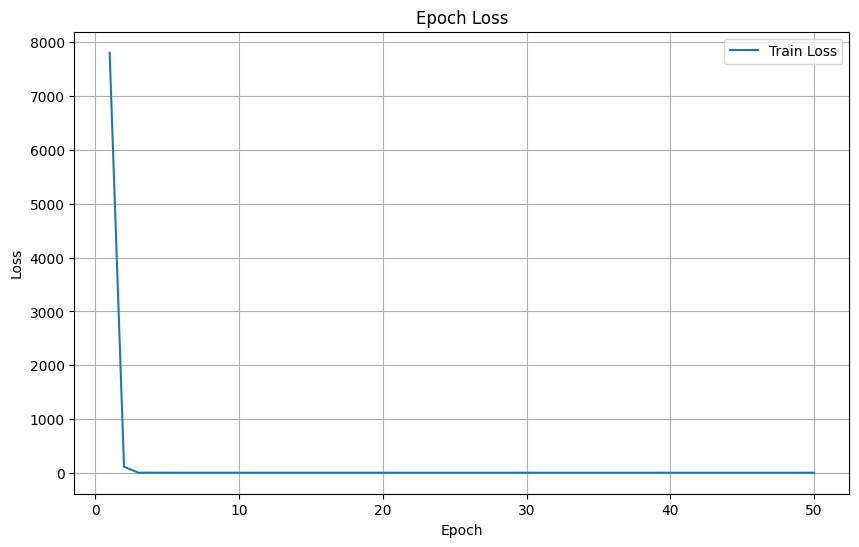

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(list(train_loss.keys()), list(train_loss.values()), label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()
plt.grid(True)
plt.show()

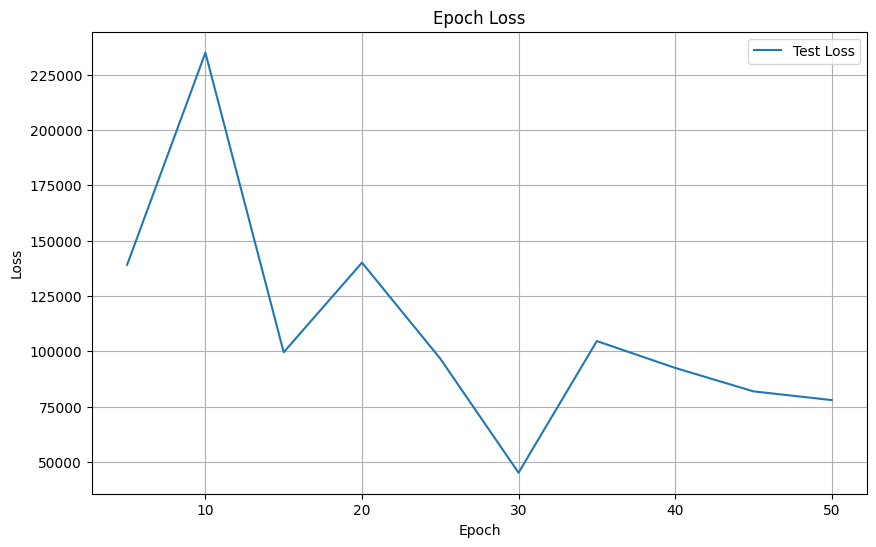

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(list(test_loss.keys()), list(test_loss.values()), label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.legend()
plt.grid(True)
plt.show()

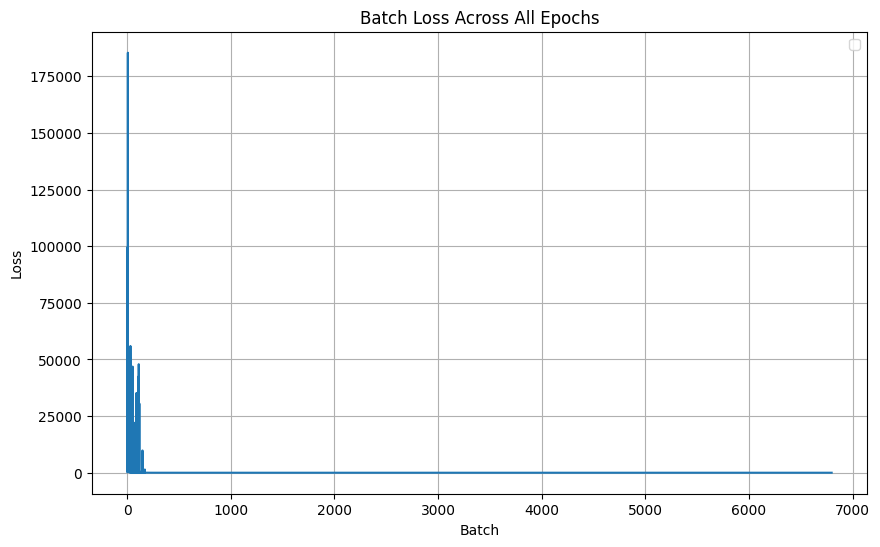

In [ ]:
# Plotting at the Batch Level
to_plot = []
plt.figure(figsize=(10, 6))
for epoch, losses in batch_train_loss.items():
  to_plot.extend(losses)
plt.plot(list(range(len(to_plot))), to_plot)

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Batch Loss Across All Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sampled_chain = save_and_sample_chain(model, args, device, dataset_info, prop_dist, epoch=epoch)

In [ ]:
sampled_chain[2][0]

tensor([[-35.4653,  -4.2618,  29.7273],
        [-26.2353,  22.3063,  36.7060],
        [ 14.4900, -33.6202,  43.6899],
        ...,
        [-36.4966, -16.3519,  -0.4701],
        [ 17.0293,  15.5812,  16.4488],
        [ 32.8387, -37.5297, -11.8625]], device='cuda:0')

In [ ]:
sample_different_sizes_and_save(model, nodes_dist, args, device, dataset_info,
                                      prop_dist, epoch=epoch)

In [6]:
from src.qm9.visualizer import *

In [16]:
# prompt: Spread out the x,y,z coordinates of the positions

def scale_positions(positions, scale_axis=[2,2,2]):
  spread_coordinates = positions * np.array(scale_axis)

  return spread_coordinates

In [ ]:
# !pip install plotly

### Plotting of Generated Sequences

In [17]:
import numpy as np
from scipy.spatial import cKDTree
import plotly.graph_objects as go

def plot_protein(positions, atom_type, k=5):
  num_atoms = len(positions)
  atom_positions = positions
  atom_types = atom_type

  # Define atom colors based on type
  type_to_color = plotly_colors = {
      "1": "#1f77b4",  # Blue
      "2": "#ff7f0e",  # Orange
      "3": "#2ca02c",  # Green
      "4": "#d62728",  # Red
      "5": "#9467bd",  # Purple
      "6": "#8c564b",  # Brown
      "7": "#e377c2",  # Pink
      "8": "#7f7f7f",  # Gray
      "9": "#bcbd22",  # Yellow-Green
      "10": "#17becf",  # Teal
      "11": "#ff9896",  # Light Coral
      "12": "#98df8a",  # Light Green
      "13": "#c49c94",  # Tan
      "14": "#f7b6d2",  # Light Pink
      "15": "#c5b0d5",  # Lavender
      "16": "#c7c7c7",  # Silver
      "17": "#dbdb8d",  # Pale Gold
      "18": "#9edae5",  # Pale Teal
      "19": "#393b79",  # Navy Blue
      "20": "#5254a3",  # Royal Blue
      "21": "#6b6ecf",  # Indigo
      "22": "#9c9ede",  # Periwinkle
      "23": "#637939",  # Olive
      "24": "#8ca252",  # Olive Green
      "25": "#b5cf6b",  # Yellow-Green
      "0": "#cedb9c"   # Light Olive
  }
  atom_colors = [type_to_color[str(atype)] for atype in atom_types]

  # Step 1: Build kNN graph
  tree = cKDTree(atom_positions)
  distances, neighbors = tree.query(atom_positions, k=k+1)  # k+1 because it includes the point itself

  # Edges: Collect edges and weights
  edges = []
  weights = []
  for i, (dist, nbrs) in enumerate(zip(distances, neighbors)):
      for j, (d, nbr) in enumerate(zip(dist[1:], nbrs[1:])):  # Skip self-reference
          edges.append((i, nbr))
          weights.append(1 / d)  # Weight inversely proportional to distance

  # Step 2: Prepare for Plotly visualization
  # Scatter points
  scatter = go.Scatter3d(
      x=atom_positions[:, 0],
      y=atom_positions[:, 1],
      z=atom_positions[:, 2],
      mode='markers',
      marker=dict(size=6, color=atom_colors),
      text=[f"Type: {atype}" for atype in atom_types],
      hoverinfo="text"
  )

  # Bonds (edges)
  edge_x, edge_y, edge_z = [], [], []
  edge_widths = []
  for (src, dst), weight in zip(edges, weights):
      edge_x += [atom_positions[src, 0], atom_positions[dst, 0], None]
      edge_y += [atom_positions[src, 1], atom_positions[dst, 1], None]
      edge_z += [atom_positions[src, 2], atom_positions[dst, 2], None]
      edge_widths.append(weight)

  # Create 3D line traces for edges
  edges_trace = go.Scatter3d(
      x=edge_x,
      y=edge_y,
      z=edge_z,
      mode='lines',
      line=dict(color='gray', width=1),  # Scale line width
      hoverinfo="none"
  )

  # Combine traces
  fig = go.Figure(data=[scatter, edges_trace])
  fig.update_layout(
      scene=dict(
          xaxis=dict(title="X"),
          yaxis=dict(title="Y"),
          zaxis=dict(title="Z")
      ),
      title="3D kNN Graph of Atoms",
      showlegend=False
  )

  # Show the plot
  fig.show()

In [ ]:
# Input path to sampled protein molecule file
mol_file = "notebooks/chain/chain_001.txt"
positions, one_hot, _ = load_molecule_xyz(mol_file, dataset_info)
atom_type = torch.argmax(one_hot, dim=1).numpy()
coordinates_spread = scale_positions(positions, [1,1,1])
plot_protein(coordinates_spread, atom_type, k=2)

In [ ]:
%matplotlib inline

coordinates_spread = scale_positions(positions, [1,1,1])
plot_protein(coordinates_spread, atom_type, k=3)